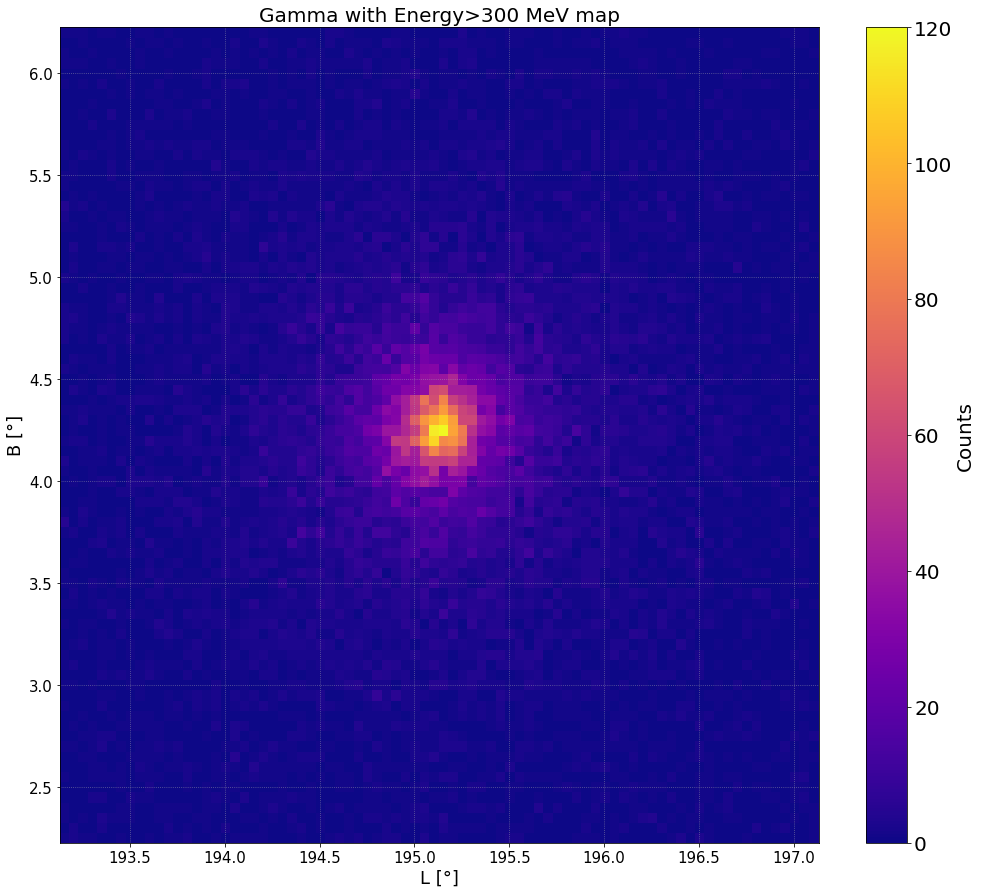

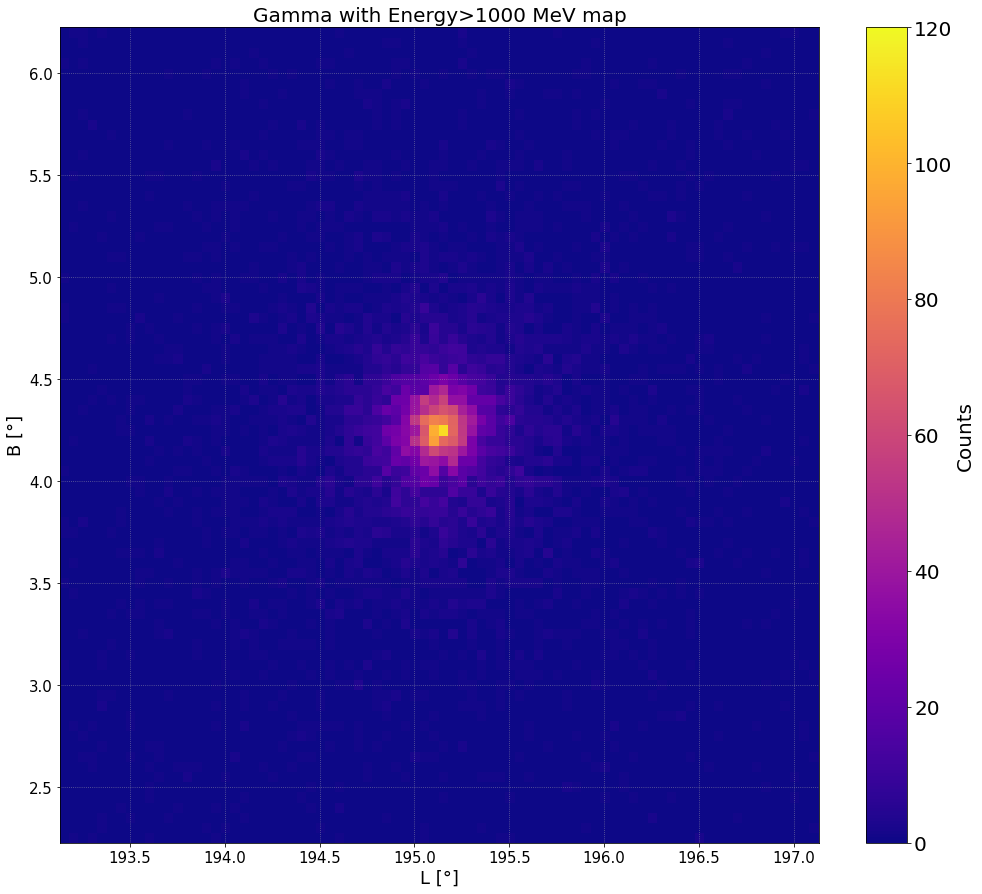

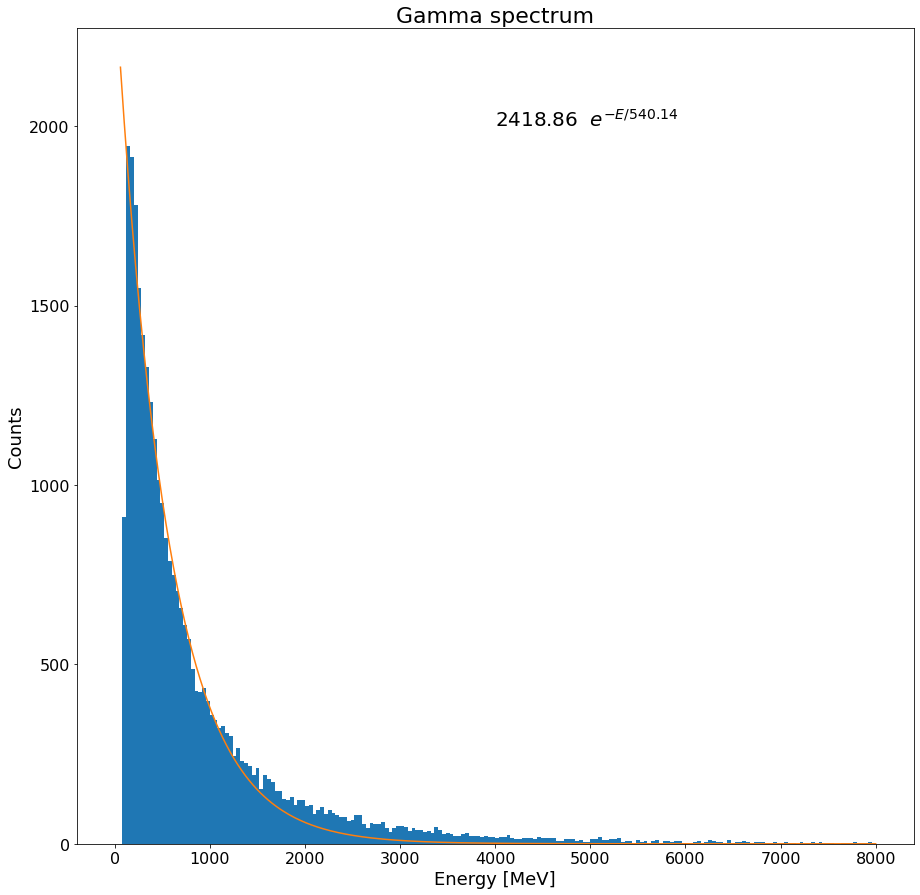

<ipython-input-1-a0ae4ad01434>:218: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().yaxis.get_offset_text().set_size(18)
<ipython-input-1-a0ae4ad01434>:219: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().xaxis.get_offset_text().set_size(18)


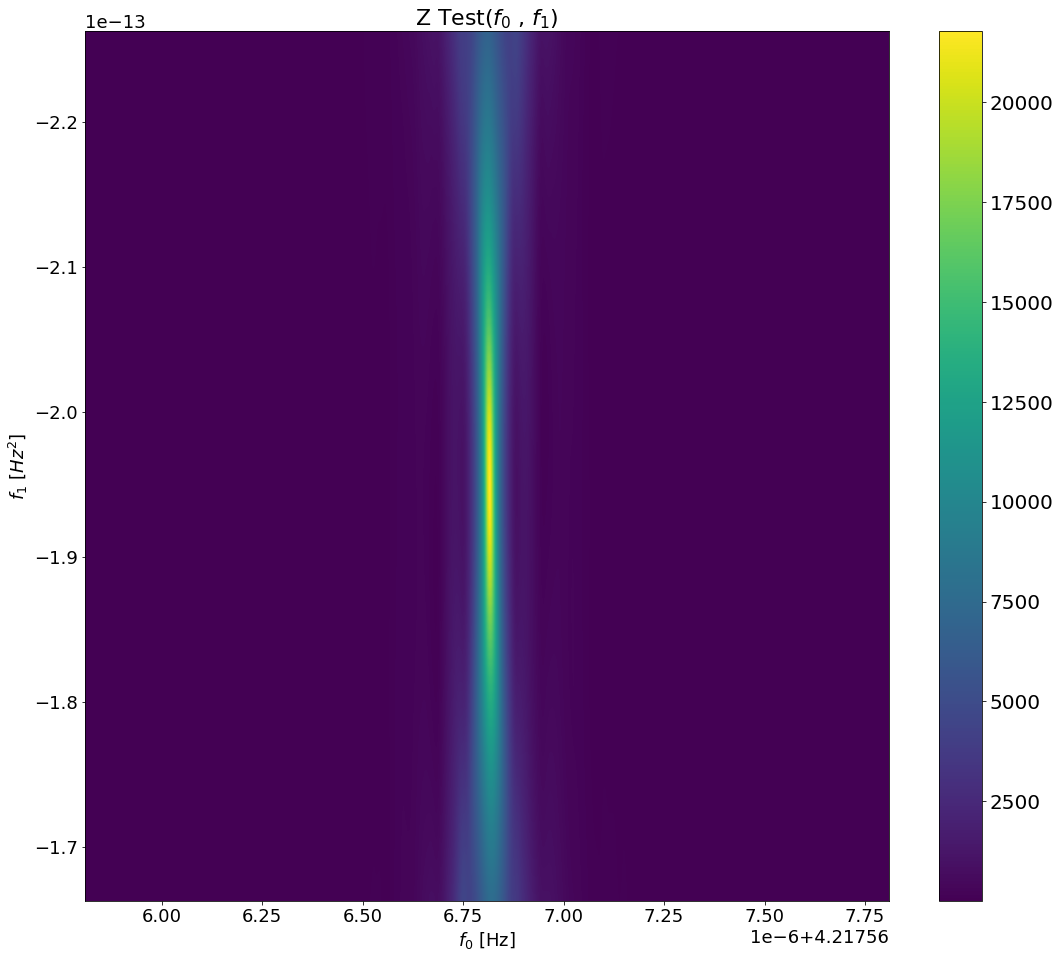

<ipython-input-1-a0ae4ad01434>:240: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().yaxis.get_offset_text().set_size(18)


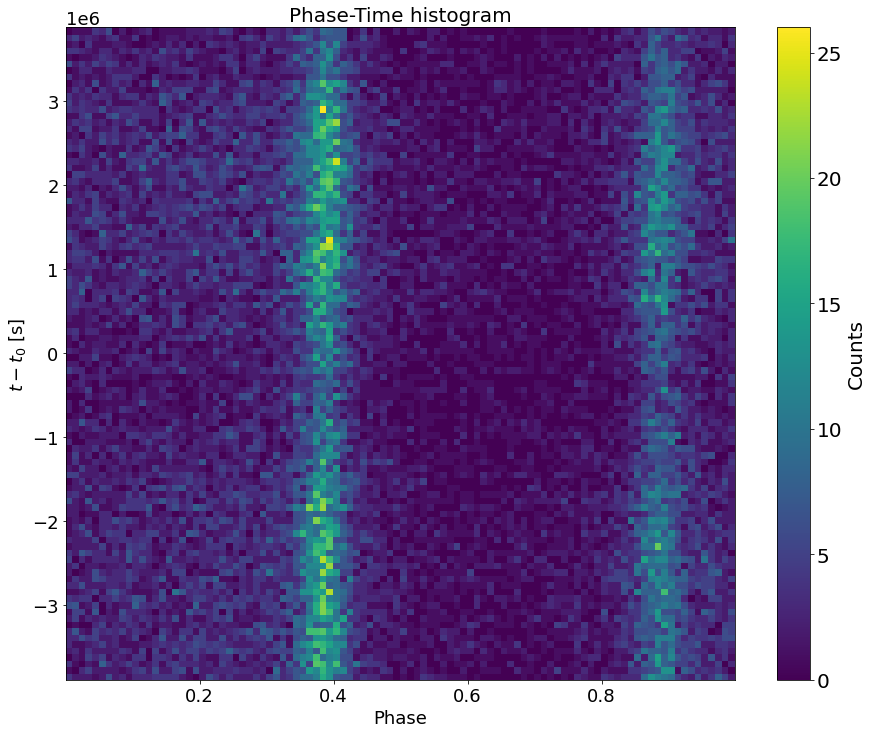

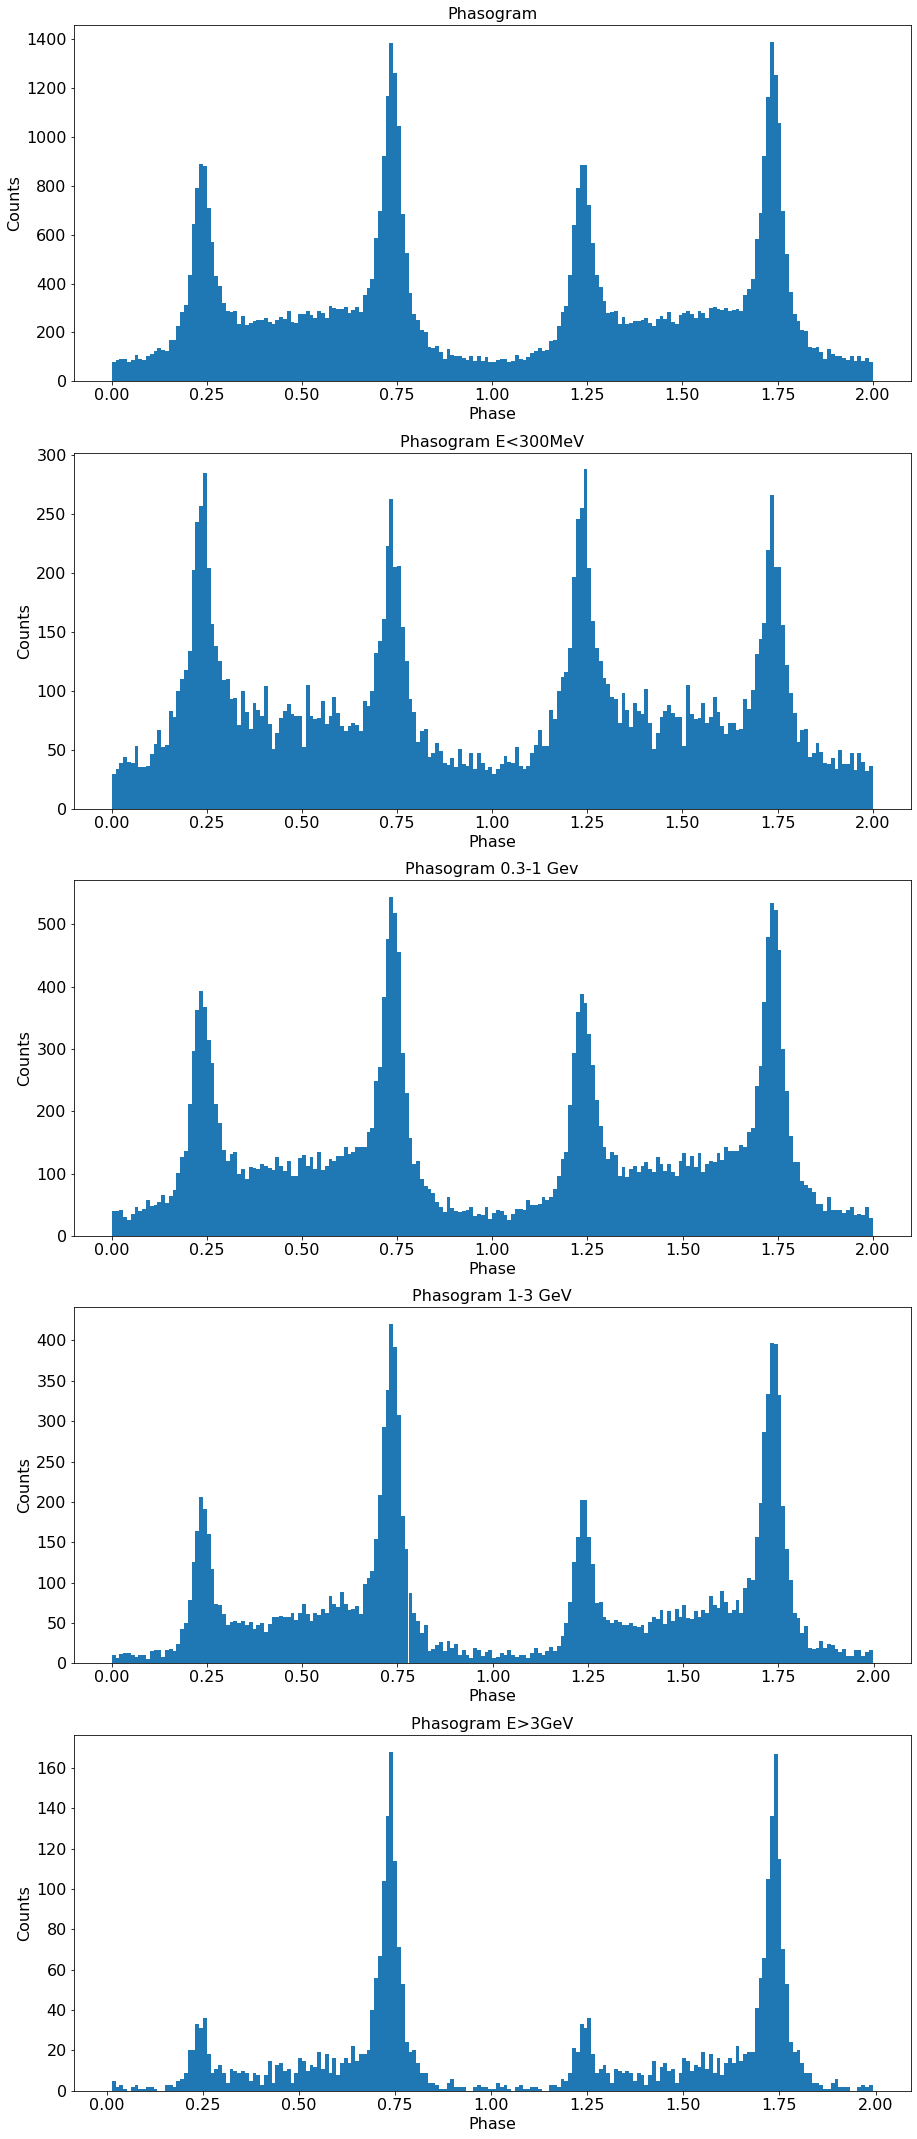

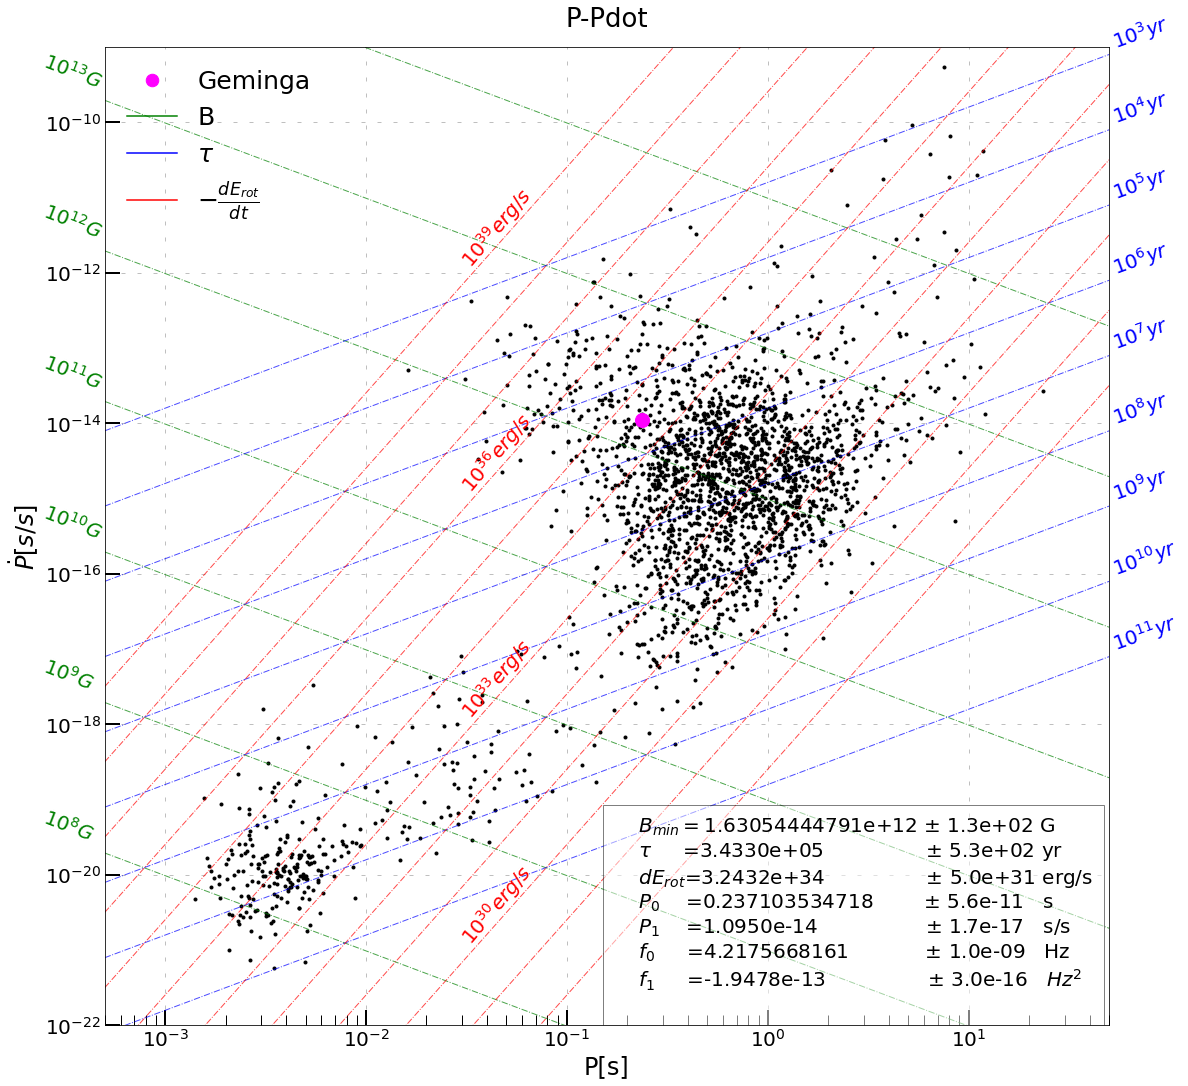

' \nprint(f"B={bary.B:.11e} +- {bary.dB:.1e} G \ntau={bary.tau/(60*60*24*365):.4e} +- {bary.dtau/(60*60*24*365):.1e} yr \ndE_rot={bary.dE_rot:.4e} +- {bary.dE:.1e} erg/s \nP_0={bary.p0_best:.11f} +- {bary.dp0:.1e} s\nP_1={bary.p1_best:.4e} +- {bary.dp1:.1e} s/s\nf_0=[{bary.f0_best:.10f} +- {bary.df0:.1e} Hz \nf_1={bary.f1_best:.4e} +- {bary.df1:.1e} Hz^2\nztest_max={bary.z_test_max:.2e} \n")\n'

In [1]:
import os 
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
#import ztest
from numba import jit
from matplotlib.lines import Line2D

src_dir = os.getcwd()
main_dir = os.path.dirname(src_dir)
data_dir=os.path.join(main_dir, "data")
results_dir = os.path.join(main_dir, "results")

f0_start=4.2175
f1_start=-1.95250e-13
t0= 250992001

class Data():
    def __init__(self,fit_name,ztest_load=False):
        self.fit_file=fits.open(os.path.join(data_dir,fit_name))
        self.data=Table(self.fit_file[1].data)
        self.gti=Table(self.fit_file[2].data)
        self.data_header=self.fit_file[1].header
        self.gti_header=self.fit_file[2].header
        self.ph_time=np.array(self.data["TIME"])-t0
        if ztest_load==True:      
            self.load()
        """ 
        self.z_test
        self.z_test_max
        self.f0_best
        self.f1_best
        self.f0_arr
        self.f1_arr
        self.phase 
        self.df0
        self.df1
        """
        
    def __repr__(self):
        return str(self.data)
    
    def __len__(self):
        return len(self.data)
    
    def mapping(self,energy,vmax=120):
        gamma_E=self.data[self.data["ENERGY"]>energy]
        plt.figure(figsize=(17,15))
        plt.subplot(111)
        xm=195.1317
        d=2
        x0=xm-d
        x1=xm+d
        ym=4.2252836
        y0=ym-d
        y1=ym+d
        plt.hist2d(gamma_E["L"],gamma_E["B"],cmap='plasma',vmax=vmax,bins=(80,80),range=[[x0,x1],[y0,y1]])
        cb=plt.colorbar()
        cb.ax.tick_params(labelsize=20)
        cb.set_label(label="Counts",size=20)
        plt.xlabel("L [°]",fontsize=18)
        plt.ylabel("B [°]",fontsize=18)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
        plt.grid(alpha=0.6,linestyle=":")
        #plt.xlim(194.1317,196.1317)
        #plt.ylim(3.4252836,5.0252836)
        plt.title(f"Gamma with Energy>{energy} MeV map",fontsize=20)
        plt.show()
        
    def aitoff(self):
        plt.figure(figsize=(15,10))
        plt.subplot(111,projection='aitoff')
        l=np.array([x if x<180 else x-360 for x in self.data[self.data["L"]>180]["L"]])*np.pi/180
        plt.plot(l[10],self.data["B"][10]*np.pi/180,".",markersize=25)
        plt.title("Geminga position in Galactic coordinates",fontsize=20,pad=30)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.grid()
        plt.show()
        
    def energy_plot(self,e_min=0,e_max=8000):
        #plt.figure(figsize=(15,15))
        #hist=plt.hist(self.data["ENERGY"],bins=200,range=(0,8000))
        hist=plt.hist(self.data["ENERGY"],bins=200,range=(e_min,e_max))
        def exp(x,a,t):
            return a*np.exp(-x/t)
        popt,pcov=curve_fit(exp,hist[1][3:-1],hist[0][3:],p0=[2000,1000])
        x=np.linspace(60,e_max,400)
        plt.plot(x,exp(x,*popt))
        plt.xlabel("Energy [MeV]")
        plt.ylabel("Counts")
        plt.title("Gamma spectrum")
        #plt.xticks(fontsize=16)
        #plt.yticks(fontsize=16)
        plt.text(4000,2000,f"{popt[0]:.2f}  $e^ {'{'} -E/{popt[1]:.2f} {'}'} $")
        #plt.plot(hist[1][3:-1],hist[0][3:],".")
        plt.show()
        return popt
    
        
    
    def load(self):
        self.z_test=np.load(os.path.join(data_dir,"z_test.npy"))
        self.f0_arr=np.load(os.path.join(data_dir,"f0_arr.npy"))
        self.f1_arr=np.load(os.path.join(data_dir,"f1_arr.npy"))
        self.phase=np.load(os.path.join(data_dir,"phase.npy"))
        self.z_test_max=np.max(self.z_test)
        self.z_test_min=np.min(self.z_test)
        f_best_index=np.unravel_index(np.argmax(self.z_test),self.z_test.shape)
        self.f0_best=self.f0_arr[f_best_index[1]]
        self.f1_best=self.f1_arr[f_best_index[0]]
        self.df0=(self.f0_arr[2]-self.f0_arr[1])/2
        self.df1=(self.f1_arr[2]-self.f1_arr[1])/2
        self.p0_best=1/self.f0_best
        self.p1_best=-self.f1_best/(self.f0_best**2)
        self.dp0=(self.df0/(self.f0_best**2))
        self.dp1=np.sqrt(((2*self.f1_best*self.df0/(self.f0_best**3))**2)+((self.df1/(self.f0_best**2))**2))
        self.values()
        
    def save(self):
    
        np.save(os.path.join(data_dir,"z_test.npy"),self.z_test)
        np.save(os.path.join(data_dir,"f0_arr.npy"),self.f0_arr)
        np.save(os.path.join(data_dir,"f1_arr.npy"),self.f1_arr)
        np.save(os.path.join(data_dir,"phase.npy"),self.phase)

    ###!DEPRECATED ZTEST WITH FORTRAN: GIVE ARITHMETIC ERRORS THAT MESS EVERYTHING
    """       
    def ztest(self, save=False,
                    f0_start=4.21786,
                    delta0=  0.00004,
                    n0=500,
                    #f1_start=-1.9525000000000000e-13,
                    f1_start=-1.951e-13,
                    delta1=5.00000e-16,
                    n1=100,
                    n_harm=10):   

            

        self.f0_arr=np.linspace(f0_start-delta0,f0_start+delta0,n0)
        self.f1_arr=np.linspace(f1_start-delta1,f1_start+delta1,n1)
        z_test=ztest.mod.matrix(self.ph_time,self.f0_arr,self.f1_arr,len(self.data),n_harm,len(self.f0_arr),len(self.f1_arr))
        self. z_test=(2/len(self.data))*z_test
        self.z_test_max=np.max(z_test)
        arg=np.argmax(z_test)
        f_best_index=np.unravel_index(arg,z_test.shape)
        self.f0_best=self.f0_arr[f_best_index[0]]
        self.f1_best=self.f1_arr[f_best_index[1]]
        self.phase=((self.f0_best*self.ph_time+(self.f1_best*np.power(self.ph_time,2))/2)%1)*2*np.pi
        
        if save==True:
            self.save()            
        
        
        return [self.f0_best,self.f1_best,self.z_test_max]
    """
    @jit
    def phase_func(self,f0,f1):
        return ((f0*self.ph_time+(f1*np.power(self.ph_time,2))/2)%1)*2*np.pi

    
    @jit   
    def ztest_func(self,phase,n_harm):
        k=np.arange(1,n_harm+1)
        k=np.reshape(k,(k.shape[0],1))
        return (2/len(self.data))*np.sum(np.power(np.sum(np.cos(phase*k),axis=1),2)+np.power(np.sum(np.sin(phase*k),axis=1),2))

        
    @jit    
    def ztest(self, save=False,
                    f0_start=4.2175668090730865,                    
                    df0=     0.000001,
                    n0=1000,
                    f1_start=-1.962982374132375e-13,
                    df1=3e-14,
                    n1=100,
                    n_harm=10):
        self.f0_arr=np.linspace(f0_start-df0,f0_start+df0,n0)
        self.f1_arr=np.linspace(f1_start-df1,f1_start+df1,n1)
        self.z_test=np.array([[self.ztest_func(self.phase_func(f0,f1),n_harm) for f0 in self.f0_arr] for f1 in self.f1_arr])
        self.z_test_max=np.max(self.z_test)
        self.z_test_min=np.min(self.z_test)
        arg=np.argmax(self.z_test)
        f_best_index=np.unravel_index(arg,self.z_test.shape)
        self.f0_best=self.f0_arr[f_best_index[1]]
        self.f1_best=self.f1_arr[f_best_index[0]]
        self.phase=self.phase_func(self.f0_best,self.f1_best)
        self.df0=df0/(2*n0)
        self.df1=df1/(2*n1)
        self.p0_best=1/self.f0_best
        self.p1_best=-self.f1_best/(self.f0_best**2)
        if save==True:
            save()
        
    
    """  def wrapp(self,f0_arr,f1_arr):
        ##! TENTATIVO DI EVITARE LIST COMPREHENSION USANDO ARRAY 3D: ENORMI RISCHI DI SBAGLIARE L' INDICE DELL' ASSE SU CUI SI SOMMA
        self.z_test=self.ztest(((self.phase(f0,f1) for f0 in f0_arr) for f1 in f1_arr))
        return
        """
    
    def ztest_map(self):
        plt.figure(figsize=(18,16))
        
        plt.imshow(self.z_test,aspect='auto',extent=[self.f0_arr[0],self.f0_arr[-1],self.f1_arr[-1],self.f1_arr[0]])
        #plt.imshow(self.z_test,aspect='auto')
        cb=plt.colorbar()
        cb.ax.tick_params(labelsize=20)
        plt.xlabel("$f_0$ [Hz]",fontsize=18)
        plt.ylabel("$f_1$ [$Hz^2$]",fontsize=18)
        plt.title("Z Test($f_0$ , $f_1$)",fontsize=22)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.axes().yaxis.get_offset_text().set_size(18)
        plt.axes().xaxis.get_offset_text().set_size(18)
        #h, w = (self.z_test).shape
        # plt.figure(figsize=(16, 8))
        #ax = plt.axes(projection='3d')
        #X, Y = np.meshgrid(np.arange(w), np.arange(h))
        #ax.plot_surface(X, Y, self.z_test, rstride=1, cstride=1, cmap='viridis', edgecolor='none', antialiased=False)
                
        plt.show()

    def scatter_phase(self):
        #plt.plot(self.phase,self.ph_time,".",markersize=2)
        plt.figure(figsize=(15,12))
        plt.hist2d(self.phase/(2*np.pi),self.ph_time,bins=(100,100))
        cb=plt.colorbar()
        cb.set_label(label="Counts",size=20)
        cb.ax.tick_params(labelsize=20)
        plt.xlabel("Phase",fontsize=18)
        plt.ylabel("$t-t_0$ [s]",fontsize=18)
        plt.title("Phase-Time histogram",fontsize=20)
        plt.xticks(size=18)
        plt.yticks(size=18)
        plt.axes().yaxis.get_offset_text().set_size(18)
        plt.show()
        
    def light_curve(self,e_min=0,e_max=500000,bins=200,offset=2.2):
        ph=self.phase[(self.data["ENERGY"]>e_min) & (self.data["ENERGY"]<e_max)]
        ph=((ph+offset)%(2*np.pi))
        ph=np.array(ph)/(2*np.pi)
        ph=np.concatenate((ph,ph+1))
        #plt.figure(figsize=(12,5))
        plt.xlabel("Phase",fontsize=16)
        plt.ylabel("Counts",fontsize=16)
        plt.xticks(size=16)
        plt.yticks(size=16)
        #plt.title("Phasogram")
        plt.hist(ph,bins)
        #plt.show()
        
        
    #don't use fit for error estimation
    def f_fit(self):
        plt.figure(figsize=(11, 10))
        #ax = plt.axes(projection='3d')
        X,Y=np.meshgrid(self.f0_arr,self.f1_arr)
        #ax.plot_surface(X, Y, self.z_test, rstride=1, cstride=1, cmap='viridis', edgecolor='none', antialiased=False)
        xdata=np.vstack((X.ravel(),Y.ravel()))
        def gauss(xy,f0,s0,f1,s1):
            x,y=xy
            return (self.z_test_max-self.z_test_min)*np.exp(-((x-f0)/s0)**2)*np.exp(-((y-f1)/s1)**2)+self.z_test_min
        
        
                
        popt,pcov=curve_fit(gauss,xdata,self.z_test.ravel(),p0=[self.f0_best,0.000000001,self.f1_best,1.5e-14])
        #ax.plot_surface(X, Y, gauss((X,Y),*popt), rstride=1, cstride=1, cmap='viridis', edgecolor='none', antialiased=False)
        plt.imshow(gauss((X,Y),*popt),aspect='auto',extent=[self.f0_arr[0],self.f0_arr[-1],self.f1_arr[-1],self.f1_arr[0]])
        plt.colorbar()
        #t=np.linspace(0,2*np.pi,1000)
        #plt.plot(popt[1]+5*np.sqrt(pcov[1][1])*np.cos(t),popt[3]+5*np.sqrt(pcov[3][3])*np.sin(t),'r')        
        #plt.plot(popt[1],popt[3],".")
        plt.ylim(self.f1_arr[-1],self.f1_arr[0])
        plt.ylabel("f1 [$Hz^2$]")
        plt.xlabel("f0 [$Hz$]")
        plt.title("Ztest fit")
        plt.show()
        self.f0_fit=popt[0]
        self.f1_fit=popt[2]
        self.df0=np.sqrt(pcov[0][0])
        self.df1=np.sqrt(pcov[2][2])
        return (popt[0],np.sqrt(pcov[0][0])), (popt[2],np.sqrt(pcov[2][2]))

    def values(self):
        self.B=3.2*(10**19)*np.sqrt(-self.f1_best/(self.f0_best**3))
        self.tau=-(self.f0_best/(2*self.f1_best))
        self.dE_rot=-4*(np.pi**2)*10**(45)*self.f1_best*(self.f0_best)
        self.dB=3.2*(10**19)*np.sqrt((self.df1/(self.f0_best**3))**2+(3*self.f1_best*self.df0/(self.f0_best**4))**2)
        self.dtau=np.sqrt((self.df0/self.f1_best)**2  + (self.f0_best*self.df1/(self.f1_best**2))**2)/2
        self.dE=4*(np.pi**2)*10**(45)*np.sqrt((self.f1_best*self.df0)**2  +  (self.f0_best*self.df1)**2)

def ppdot():
    f0=[]
    f1=[]
    p0=[]
    p1=[]
    with open(os.path.join(data_dir,"psrcat.txt"), 'r') as file:
        lines=[line for line in file]
        for idx, line in enumerate(lines):
            if "F0" in line and "F1"in lines[idx+1]:
                f0.append(float(line.split()[1]))
                f1.append(float(lines[idx+1].split()[1]))
            if "P0" in line and "P1"in lines[idx+1]:
                p0.append(float(line.split()[1]))
                p1.append(float(lines[idx+1].split()[1]))
    f0top0=1/np.array(f0)
    f1top1=-np.array(f1)/(np.array(f0)**2)
    p0_arr=np.concatenate((f0top0,np.array(p0)))
    p1_arr=np.concatenate((f1top1,np.array(p1)))
    
    B= lambda p,B: (B**2)/(((3.2e19)**2)*p)
    dE_rot= lambda p,dE:dE*(p**3)/(4e45*(np.pi**2))
    tau= lambda p,tau:p/(2*tau)
    
    b_arr=np.logspace(8,14,7)
    dE_arr=np.logspace(28,39,12)
    tau_arr=np.logspace(3,11,9)
    t=np.array([(1e-3)/2,5e1])
    
    
    plt.figure(figsize=(18,18))
    plt.plot(p0_arr,p1_arr,".",markersize=6,color="black")
    
    

    plt.plot(bary.p0_best,np.abs(bary.p1_best),".",markersize=28,color="magenta",label="Geminga")
    for b in b_arr:
        plt.plot(t,B(t,b),"-.",color="green",linewidth=1,alpha=0.7)
        if int(np.log10(b))!=14:
            plt.text(t[0]/2.1,B(t[0]/2.1,b/1.2),f"$10^{'{'}{int(np.log10(b))} {'}'} G$",rotation=85*np.arctan(-1)/np.pi,color="green",fontsize=20)
    for T in tau_arr:
        T_s=T*(365*24*60*60)
        plt.plot(t,tau(t,T_s),"-.",color="blue",linewidth=1,alpha=0.7)
        plt.text(t[1]*1,tau(t[1]*1,T_s/1.2),f"$10^{'{'} {int(np.log10(T))} {'}'} yr $", rotation=80*np.arctan(1)/np.pi,fontsize=20,color="blue")
        
    for E in dE_arr:
        plt.plot(t,dE_rot(t,E),"-.",color="red",linewidth=1,alpha=0.7)
        if int(np.log10(E))%3 ==0:
            plt.text(2.8e-2,dE_rot(2.8e-2,E*2.2),f"$10^{'{'} {int(np.log10(E))} {'}'} erg/s $",rotation=125*np.arctan(3)/np.pi,color='red',fontsize=20 )
    plt.xscale('log')
    plt.yscale('log')
    plt.ylim(1e-22,1e-9)
    plt.xlim((1e-3)/2,5e1)
    plt.xlabel("P[s]",size=24)
    plt.ylabel("$ \dot{P}[s/s]$",size=24)
    plt.title("P-Pdot",size=26,pad=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    


    plt.tick_params(axis="x",length=15,width=2,direction="in")
    plt.tick_params(axis="x",which='minor',length=10,width=1,direction="in")
    plt.tick_params(axis="y",length=15,width=2,direction="in")
    plt.tick_params(axis="y",which='minor',length=10,width=1,direction="in")
    colors = ['red', 'blue', 'green']
    lines = [Line2D([0], [0], color=c, linewidth=1.5, linestyle='-') for c in colors]
    lines.append(Line2D([0], [0], color="magenta",marker=".",markersize=25,lw=0))
    labels = ['$-\\frac{dE_{rot}}{dt}$', '$ \\tau $',"B", "Geminga" ]
    plt.legend(lines[::-1],labels[::-1],fontsize=25,frameon=False)
    plt.grid(linestyle=(0,(5,15)))
    
    string=f"    $B_{'{'}min{'}'}=${bary.B:.11e} $ \pm $ {bary.dB:.1e} G \n\
    $\\tau$     ={bary.tau/(60*60*24*365):.4e}                $ \pm $ {bary.dtau/(60*60*24*365):.1e} yr \n\
    $dE_{'{'}rot{'}'}$={bary.dE_rot:.4e}                $ \pm $ {bary.dE:.1e} erg/s \n\
    $P_0$    ={bary.p0_best:.12f}        $ \pm $ {bary.dp0:.1e}   s\n\
    $P_1$    ={bary.p1_best:.4e}                 $ \pm $ {bary.dp1:.1e}   s/s\n\
    $f_0$     ={bary.f0_best:.10f}            $ \pm $ {bary.df0:.1e}   Hz \n\
    $f_1$     ={bary.f1_best:.4e}                $ \pm $ {bary.df1:.1e}   $Hz^2$\n "
    plt.text(0.17e0,1.55e-22,string,bbox={'facecolor':'white','pad':10,'alpha':0.5},size=20)

    
    
    plt.show()
    


def  curves():
    plt.figure(figsize=(15,38))
    plt.subplot(511)
    bary.light_curve()
    plt.title("Phasogram",fontsize=16)
    
    plt.subplot(512)
    bary.light_curve(e_max=300)
    plt.title("Phasogram E<300MeV",fontsize=16)
    
    plt.subplot(513)
    bary.light_curve(e_min=300,e_max=1000)
    plt.title("Phasogram 0.3-1 Gev",fontsize=16)
    
    plt.subplot(514)
    bary.light_curve(e_min=1000,e_max=3000)
    plt.title("Phasogram 1-3 GeV",fontsize=16)
    
    plt.subplot(515)
    bary.light_curve(e_min=3000)
    plt.title("Phasogram E>3GeV",fontsize=16)

#bary.ztest(f0_start=4.2175668090730865,df0=0.000001,n0=1000,f1_start=-1.962982374132375e-13,df1=3e-14,n1=100)

tt=Data("PSRJ_Geminga_3deg_100mev_tt.fits")
bary=Data("PSRJ_Geminga_3deg_100mev_bary.fits",ztest_load=True)
#bary.values()




tt.mapping(300)
tt.mapping(1000)
popt=tt.energy_plot(e_min=0,e_max=500)
popt=tt.energy_plot()
bary.ztest_map()
bary.scatter_phase()
curves()

ppdot()


""" 
print(f"B={bary.B:.11e} +- {bary.dB:.1e} G \n\
tau={bary.tau/(60*60*24*365):.4e} +- {bary.dtau/(60*60*24*365):.1e} yr \n\
dE_rot={bary.dE_rot:.4e} +- {bary.dE:.1e} erg/s \n\
P_0={bary.p0_best:.11f} +- {bary.dp0:.1e} s\n\
P_1={bary.p1_best:.4e} +- {bary.dp1:.1e} s/s\n\
f_0=[{bary.f0_best:.10f} +- {bary.df0:.1e} Hz \n\
f_1={bary.f1_best:.4e} +- {bary.df1:.1e} Hz^2\n\
ztest_max={bary.z_test_max:.2e} \n\
")
"""

#TODO Remove some reduncancies in save/load functions and remove obsolete comments
